In [1]:
%pip install transformers torch torchvision matplotlib


Note: you may need to restart the kernel to use updated packages.


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from transformers import BeitModel, BeitFeatureExtractor, BeitForImageClassification
import matplotlib.pyplot as plt


2024-11-09 03:05:22.903657: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
labels = ['PNEUMONIA', 'NORMAL']
img_size =244
def get_training_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [4]:
# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to match BEiT's expected input size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Standard BEiT normalization
])


In [5]:
# Path to the dataset directories
train_dir = 'chest/chest/chest_xray/chest_xray/train'
test_dir = 'chest/chest/chest_xray/chest_xray/test'

# Load the dataset using ImageFolder
train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Check number of classes
num_classes = len(train_dataset.classes)
print(f"Number of classes: {num_classes}")


Number of classes: 2


In [6]:
import os
import torch
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, WeightedRandomSampler
import numpy as np

# Define data augmentations for training
train_transforms = transforms.Compose([
    transforms.RandomRotation(15),
    transforms.RandomHorizontalFlip(),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Define transformations for validation (only resizing and normalization)
val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load datasets with transformations
train_dataset = ImageFolder(root='chest/chest/chest_xray/chest_xray/train', transform=train_transforms)
val_dataset = ImageFolder(root='chest/chest/chest_xray/chest_xray/val', transform=val_transforms)

# Count the number of images in each class in the training set
class_counts = [len(os.listdir(os.path.join('chest/chest/chest_xray/chest_xray/train', cls))) for cls in train_dataset.classes]
num_normal, num_pneumonia = class_counts
print(f"Class distribution before balancing - Normal: {num_normal}, Pneumonia: {num_pneumonia}")

# Calculate class weights to balance the dataset
weights = [1.0 / num_normal if label == 0 else 1.0 / num_pneumonia for _, label in train_dataset]

# Create a WeightedRandomSampler to sample with replacement based on class weights
sampler = WeightedRandomSampler(weights, num_samples=max(class_counts) * 2, replacement=True)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, sampler=sampler)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Print the first batch for sanity check
data_iter = iter(train_loader)
images, labels = next(data_iter)

print(f"Batch of {images.shape[0]} images - Labels: {labels}")


Class distribution before balancing - Normal: 1342, Pneumonia: 3876
Batch of 32 images - Labels: tensor([1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0,
        0, 1, 1, 1, 1, 0, 0, 1])


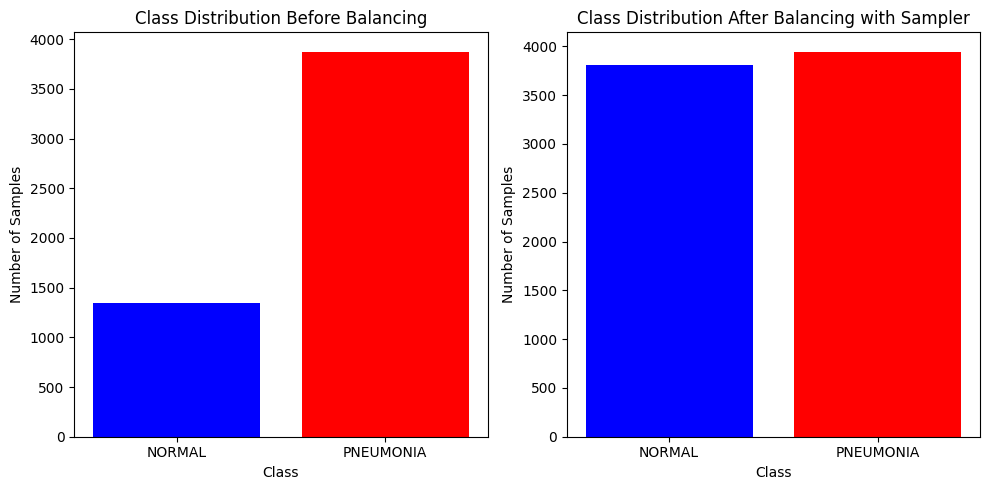

In [7]:
import matplotlib.pyplot as plt

# Plot class distribution before balancing
train_class_counts = [len([i for i in range(len(train_dataset.targets)) if train_dataset.targets[i] == label]) for label in range(len(train_dataset.classes))]

# Create a dictionary for class labels
class_labels = train_dataset.classes

# Plot before balancing
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.bar(class_labels, train_class_counts, color=['blue', 'red'])
plt.title('Class Distribution Before Balancing')
plt.xlabel('Class')
plt.ylabel('Number of Samples')

# Plot class distribution after balancing
# Create a list of labels sampled using the WeightedRandomSampler
sampled_labels = [train_dataset.targets[i] for i in sampler]

# Count the number of instances for each class in the sampled data
sampled_class_counts = [sampled_labels.count(label) for label in range(len(train_dataset.classes))]

# Plot after balancing
plt.subplot(1, 2, 2)
plt.bar(class_labels, sampled_class_counts, color=['blue', 'red'])
plt.title('Class Distribution After Balancing with Sampler')
plt.xlabel('Class')
plt.ylabel('Number of Samples')

# Display the plot
plt.tight_layout()
plt.show()


In [8]:
# Load BEiT model and feature extractor
model_name = 'microsoft/beit-base-patch16-224-pt22k-ft22k'
feature_extractor = BeitFeatureExtractor.from_pretrained(model_name)

# Load the pre-trained BEiT model with the original classifier (ignore mismatched sizes)
model = BeitForImageClassification.from_pretrained(model_name, num_labels=num_classes, ignore_mismatched_sizes=True)

# Now replace the classifier with a new one for binary classification (pneumonia vs normal)
model.classifier = nn.Linear(model.config.hidden_size, num_classes)


/opt/conda/lib/python3.10/site-packages/transformers/models/beit/feature_extraction_beit.py:28: FutureWarning: The class BeitFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use BeitImageProcessor instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/transformers/utils/deprecation.py:165: UserWarning: The following named arguments are not valid for `BeitFeatureExtractor.__init__` and were ignored: 'feature_extractor_type'
  return func(*args, **kwargs)
Some weights of BeitForImageClassification were not initialized from the model checkpoint at microsoft/beit-base-patch16-224-pt22k-ft22k and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([21841, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([21841]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream

In [9]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4)


In [10]:
from tqdm import tqdm
import torch

def train_model(model, train_loader, criterion, optimizer, num_epochs=5, device='cuda'):
    model.to(device)  # Move model to the specified device (GPU/CPU)
    
    train_losses = []
    train_accuracies = []

    # Set num_workers for faster data loading
    train_loader = torch.utils.data.DataLoader(train_loader.dataset, batch_size=train_loader.batch_size, 
                                               shuffle=True, num_workers=4, pin_memory=True)
    
    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        running_loss = 0.0
        correct = 0
        total = 0
        
        # Use tqdm for a progress bar within the batch loop
        with tqdm(total=len(train_loader), desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch") as pbar:
            for images, labels in train_loader:
                images, labels = images.to(device, non_blocking=True), labels.to(device, non_blocking=True)

                # Forward pass
                outputs = model(images).logits
                loss = criterion(outputs, labels)

                # Backward and optimize
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                # Track running loss and accuracy
                running_loss += loss.item() * images.size(0)
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)

                # Update the tqdm progress bar
                pbar.set_postfix(loss=loss.item())
                pbar.update(1)

        # Calculate loss and accuracy for the epoch
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_accuracy = 100 * correct / total

        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_accuracy)

        print(f"Epoch [{epoch+1}/{num_epochs}], Total Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%")

    return train_losses, train_accuracies


In [30]:
# Evaluation function
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images).logits
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Accuracy on test set: {accuracy:.2f}%')


In [12]:
# Train the model
torch.cuda.empty_cache()
num_epochs = 5
train_model(model, train_loader, criterion, optimizer, num_epochs)


Epoch 1/5:   0%|                                                    | 0/163 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Epoch 1/5: 100%|██████████████████████████████| 163/163 [54:55<00:00, 19.62s/batch, loss=0.231]/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Epoch 1/5: 100%|██████████████████████████████| 163/163 [54:55<00:00, 20.22s/batch, loss=0.231]


Epoch [1/5], Total Loss: 0.2643, Accuracy: 88.38%


Epoch 2/5: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 163/163 [53:32<00:00, 19.71s/batch, loss=0.0908]


Epoch [2/5], Total Loss: 0.1249, Accuracy: 95.19%


Epoch 3/5: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 163/163 [53:29<00:00, 19.69s/batch, loss=0.0049]


Epoch [3/5], Total Loss: 0.1053, Accuracy: 96.11%


Epoch 4/5: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 163/163 [53:36<00:00, 19.73s/batch, loss=0.0422]


Epoch [4/5], Total Loss: 0.0836, Accuracy: 97.18%


Epoch 5/5: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 163/163 [53:35<00:00, 19.73s/batch, loss=0.0705]

Epoch [5/5], Total Loss: 0.0821, Accuracy: 96.61%


([0.2643381508490059,
  0.12490690017598996,
  0.1052854811541302,
  0.08359115803042895,
  0.08209469873405296],
 [88.3819018404908,
  95.18788343558282,
  96.10812883435582,
  97.18174846625767,
  96.60659509202453])

In [31]:
# Evaluate the model
evaluate_model(model, test_loader)

Accuracy on test set: 94.07%


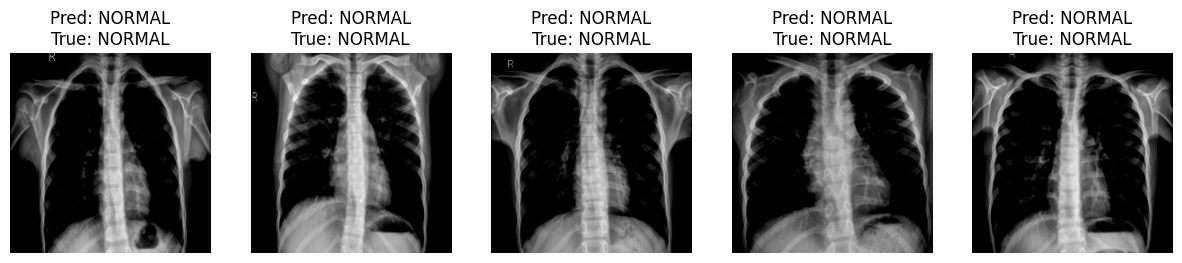

In [ ]:
# Visualize some predictions
def visualize_predictions(model, test_loader):
    model.eval()
    images, labels = next(iter(test_loader))
    images, labels = images.to(device), labels.to(device)

    # Make predictions
    with torch.no_grad():
        outputs = model(images).logits
        _, predicted = torch.max(outputs, 1)

    # Plot some images and predictions
    fig, axes = plt.subplots(1, 5, figsize=(15, 5))
    for i in range(5):
        ax = axes[i]
        ax.imshow(images[i].cpu().permute(1, 2, 0).numpy())
        ax.set_title(f"Pred: {train_dataset.classes[predicted[i]]}\nTrue: {train_dataset.classes[labels[i]]}")
        ax.axis('off')
    plt.show()

# Visualize predictions on the test set
visualize_predictions(model, test_loader)


In [15]:
# Save the trained model
torch.save(model.state_dict(), 'beit_pneumonia_model.pth')
print("Model saved!")


Model saved!


Evaluation Loss: 0.1594, Accuracy: 94.07%


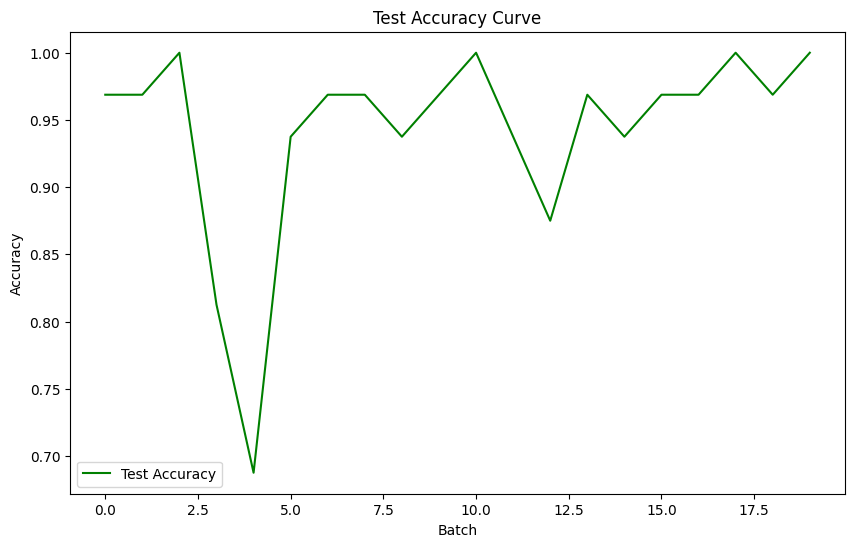

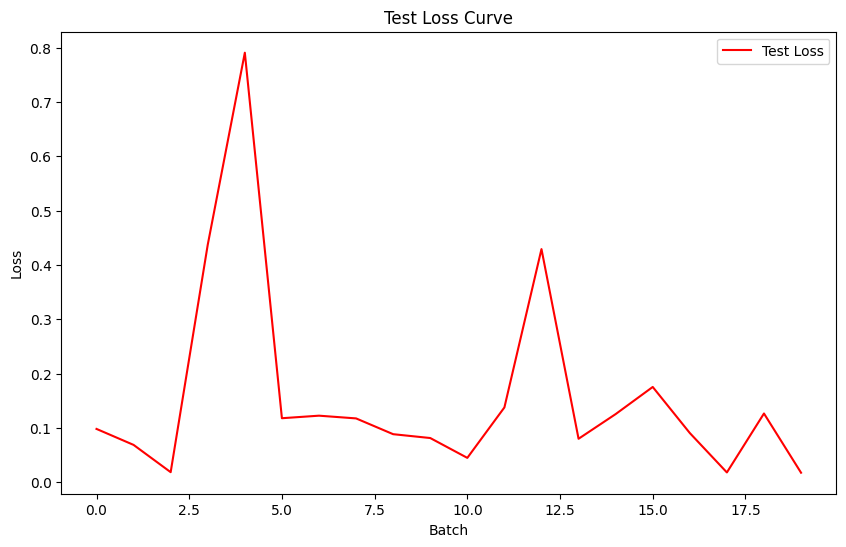

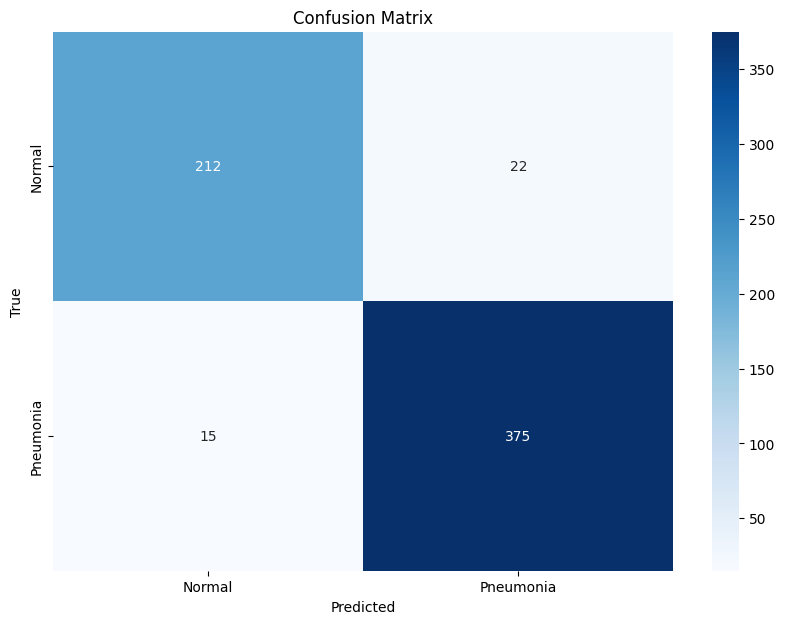

In [32]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torch
from sklearn.metrics import confusion_matrix

def evaluate_model_plots(model, test_loader, device='cuda'):
    model.eval()  # Set model to evaluation mode
    
    correct_predictions = 0
    total_predictions = 0
    total_loss = 0.0
    all_preds = []
    all_labels = []
    batch_accuracies = []  # To store batch-wise accuracy for the test accuracy curve
    batch_losses = []  # To store batch-wise loss for the loss curve

    criterion = torch.nn.CrossEntropyLoss()

    with torch.no_grad():  # No gradient calculation for evaluation
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images).logits
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            # Calculate batch accuracy
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == labels).sum().item()
            total_predictions += labels.size(0)
            
            batch_accuracy = (predicted == labels).sum().item() / labels.size(0)
            batch_accuracies.append(batch_accuracy)

            # Store batch loss
            batch_losses.append(loss.item())

            # Collect all predictions and labels for confusion matrix
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate accuracy and average loss for evaluation
    accuracy = correct_predictions / total_predictions
    avg_loss = total_loss / len(test_loader)

    print(f'Evaluation Loss: {avg_loss:.4f}, Accuracy: {accuracy * 100:.2f}%')

    # Plot the metrics
    plot_evaluation_metrics(all_labels, all_preds, avg_loss, accuracy, batch_accuracies, batch_losses)

def plot_evaluation_metrics(all_labels, all_preds, avg_loss, accuracy, batch_accuracies, batch_losses):
    # Plot the Test Accuracy Curve
    plt.figure(figsize=(10, 6))
    plt.plot(batch_accuracies, label='Test Accuracy', color='green')
    plt.xlabel('Batch')
    plt.ylabel('Accuracy')
    plt.title('Test Accuracy Curve')
    plt.legend()
    plt.show()

    # Plot the Test Loss Curve
    plt.figure(figsize=(10, 6))
    plt.plot(batch_losses, label='Test Loss', color='red')
    plt.xlabel('Batch')
    plt.ylabel('Loss')
    plt.title('Test Loss Curve')
    plt.legend()
    plt.show()

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Pneumonia'], yticklabels=['Normal', 'Pneumonia'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# Evaluate the model after training and plot the metrics
evaluate_model_plots(model, test_loader, device='cuda')
